In [1]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

### Read in the Networks

In [2]:
from discriminator import Discriminator
from generator import UNet

### Path to Data

In [3]:
# coco_path = untar_data(URLs.COCO_SAMPLE)
# coco_path = str(coco_path) + "/train_sample"
coco_path = "/Users/nelsonfarrell/.fastai/data/coco_sample/train_sample"

In [4]:
print(f"Path to data: {coco_path}")

Path to data: /Users/nelsonfarrell/.fastai/data/coco_sample/train_sample


In [5]:
paths = glob.glob(coco_path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace = False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:160] # choosing the first 8000 as training set
val_idxs = rand_idxs[160:200] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

160 40


In [ ]:
"""
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths[0:16]):
    ax.imshow(Image.open(img_path))
    ax.axis("off")
"""

### Set Up Dataset

In [6]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = (img_lab[[0], ...] / 50.) - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)


In [7]:
train_ds = ColorizationDataset(paths = train_paths, split = "train")
val_ds = ColorizationDataset(paths = val_paths, split = "val")

### Setup Dataloader

In [8]:
train_dl = DataLoader(train_ds, batch_size = 4)
val_dl = DataLoader(val_ds, batch_size = 4)

In [9]:
data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

torch.Size([4, 1, 256, 256]) torch.Size([4, 2, 256, 256])
40 10


### Setup Model

In [10]:
# Assuming UNet is already defined as per the code above
generator = UNet()
discriminator = Discriminator()

# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

# Loss functions
adversarial_loss = nn.BCELoss()  
l1_loss = nn.L1Loss()
mce = nn.MSELoss()

# Optimizers
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
lambda_l1 = 100

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# training params
epochs = 20
batch_size = 16


### Train Loop

[Epoch 0/20] [Batch 0/40] [D loss: 0.6456671953201294] [G loss: 62.747745513916016]
[Epoch 0/20] [Batch 1/40] [D loss: 0.7247223258018494] [G loss: 55.295448303222656]
[Epoch 0/20] [Batch 2/40] [D loss: 0.6896270513534546] [G loss: 50.94108581542969]
[Epoch 0/20] [Batch 3/40] [D loss: 0.7229328155517578] [G loss: 45.613468170166016]
[Epoch 0/20] [Batch 4/40] [D loss: 0.6756908893585205] [G loss: 45.05244445800781]
[Epoch 0/20] [Batch 5/40] [D loss: 0.5606898069381714] [G loss: 41.48319625854492]
[Epoch 0/20] [Batch 6/40] [D loss: 0.9661017656326294] [G loss: 41.93305206298828]
[Epoch 0/20] [Batch 7/40] [D loss: 0.7156037092208862] [G loss: 39.328067779541016]
[Epoch 0/20] [Batch 8/40] [D loss: 0.736803412437439] [G loss: 38.38505935668945]
[Epoch 0/20] [Batch 9/40] [D loss: 0.7504677176475525] [G loss: 38.52728271484375]
[Epoch 0/20] [Batch 10/40] [D loss: 0.6136240363121033] [G loss: 37.072574615478516]
[Epoch 0/20] [Batch 11/40] [D loss: 0.7277737855911255] [G loss: 37.10712432861328

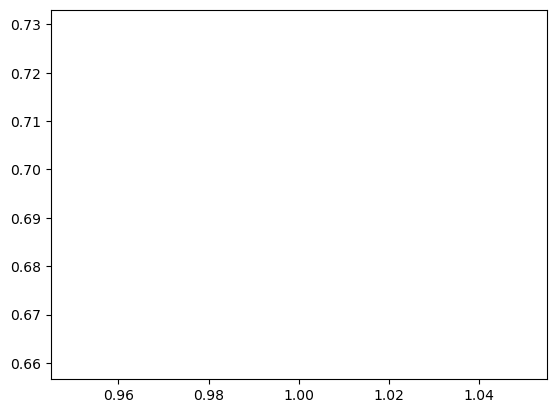

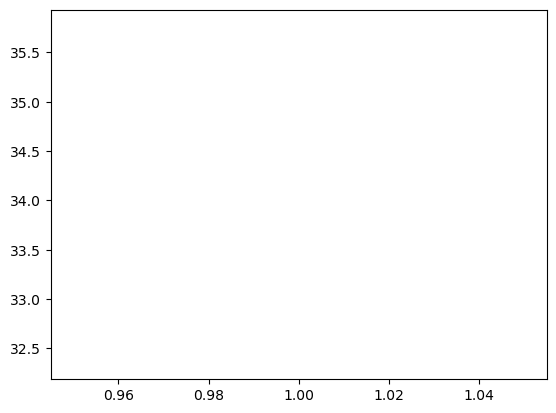

VAL: [Epoch 0/20] [Batch 0/40] [D loss: 0.2481689602136612] [G loss: 25.949373245239258]
VAL: [Epoch 0/20] [Batch 1/40] [D loss: 1.033445119857788] [G loss: 24.370725631713867]
VAL: [Epoch 0/20] [Batch 2/40] [D loss: 0.9137769341468811] [G loss: 24.866697311401367]
VAL: [Epoch 0/20] [Batch 3/40] [D loss: 0.44512423872947693] [G loss: 21.79430389404297]
VAL: [Epoch 0/20] [Batch 4/40] [D loss: 0.7789282202720642] [G loss: 24.987741470336914]
VAL: [Epoch 0/20] [Batch 5/40] [D loss: 0.9129316806793213] [G loss: 24.894859313964844]
VAL: [Epoch 0/20] [Batch 6/40] [D loss: 0.573397159576416] [G loss: 25.49135398864746]
VAL: [Epoch 0/20] [Batch 7/40] [D loss: 0.7923814654350281] [G loss: 24.87525749206543]
VAL: [Epoch 0/20] [Batch 8/40] [D loss: 1.1543388366699219] [G loss: 22.616798400878906]
VAL: [Epoch 0/20] [Batch 9/40] [D loss: 0.3929558992385864] [G loss: 25.988306045532227]
[Epoch 1/20] [Batch 0/40] [D loss: 0.6244483590126038] [G loss: 22.545503616333008]
[Epoch 1/20] [Batch 1/40] [D l

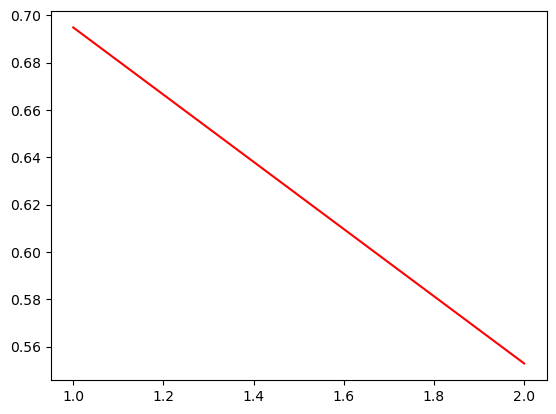

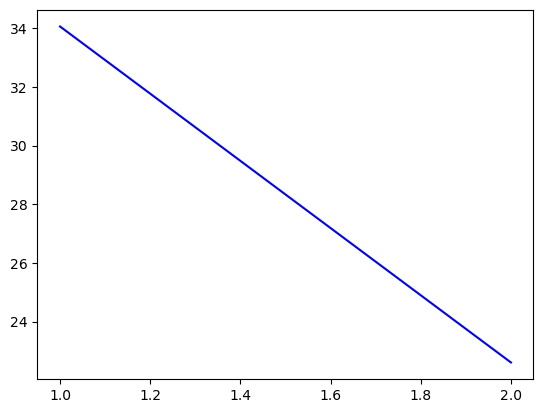

VAL: [Epoch 1/20] [Batch 0/40] [D loss: 0.49848276376724243] [G loss: 22.39822006225586]
VAL: [Epoch 1/20] [Batch 1/40] [D loss: 1.272146463394165] [G loss: 21.654565811157227]
VAL: [Epoch 1/20] [Batch 2/40] [D loss: 0.9183852672576904] [G loss: 22.083152770996094]
VAL: [Epoch 1/20] [Batch 3/40] [D loss: 1.1570160388946533] [G loss: 18.478361129760742]
VAL: [Epoch 1/20] [Batch 4/40] [D loss: 0.8343261480331421] [G loss: 21.848209381103516]
VAL: [Epoch 1/20] [Batch 5/40] [D loss: 0.9939842224121094] [G loss: 22.33354949951172]
VAL: [Epoch 1/20] [Batch 6/40] [D loss: 0.9957009553909302] [G loss: 21.963254928588867]
VAL: [Epoch 1/20] [Batch 7/40] [D loss: 0.6123803853988647] [G loss: 21.42946434020996]
VAL: [Epoch 1/20] [Batch 8/40] [D loss: 1.0449185371398926] [G loss: 19.862512588500977]
VAL: [Epoch 1/20] [Batch 9/40] [D loss: 1.0110093355178833] [G loss: 22.77843475341797]
[Epoch 2/20] [Batch 0/40] [D loss: 0.23488159477710724] [G loss: 19.431827545166016]
[Epoch 2/20] [Batch 1/40] [D 

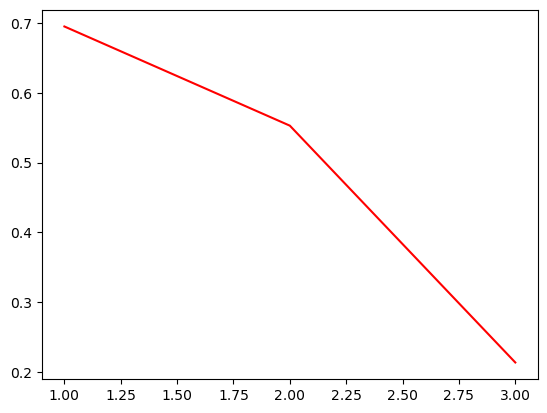

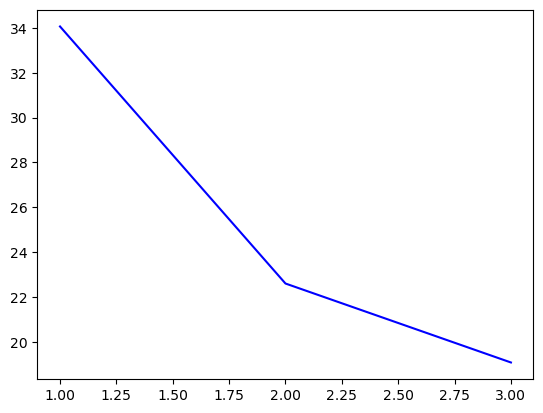

VAL: [Epoch 2/20] [Batch 0/40] [D loss: 0.318315327167511] [G loss: 19.795509338378906]
VAL: [Epoch 2/20] [Batch 1/40] [D loss: 0.6562341451644897] [G loss: 19.776927947998047]
VAL: [Epoch 2/20] [Batch 2/40] [D loss: 0.6788007020950317] [G loss: 20.01033592224121]
VAL: [Epoch 2/20] [Batch 3/40] [D loss: 0.7548270225524902] [G loss: 16.564414978027344]
VAL: [Epoch 2/20] [Batch 4/40] [D loss: 0.713386058807373] [G loss: 19.576303482055664]
VAL: [Epoch 2/20] [Batch 5/40] [D loss: 0.4982464909553528] [G loss: 20.612552642822266]
VAL: [Epoch 2/20] [Batch 6/40] [D loss: 0.8780499696731567] [G loss: 19.734575271606445]
VAL: [Epoch 2/20] [Batch 7/40] [D loss: 0.2763269245624542] [G loss: 19.0726261138916]
VAL: [Epoch 2/20] [Batch 8/40] [D loss: 0.5662344694137573] [G loss: 17.7756404876709]
VAL: [Epoch 2/20] [Batch 9/40] [D loss: 0.41650933027267456] [G loss: 20.588958740234375]
[Epoch 3/20] [Batch 0/40] [D loss: 0.29924190044403076] [G loss: 17.657320022583008]
[Epoch 3/20] [Batch 1/40] [D lo

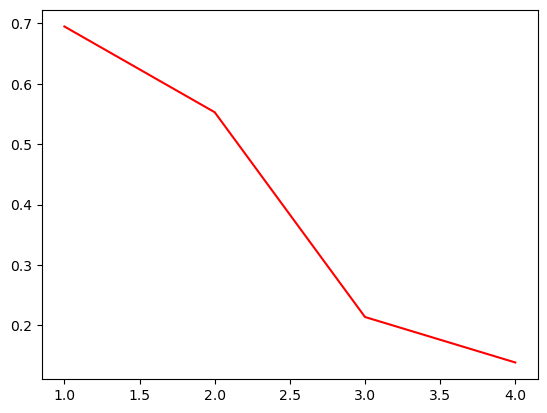

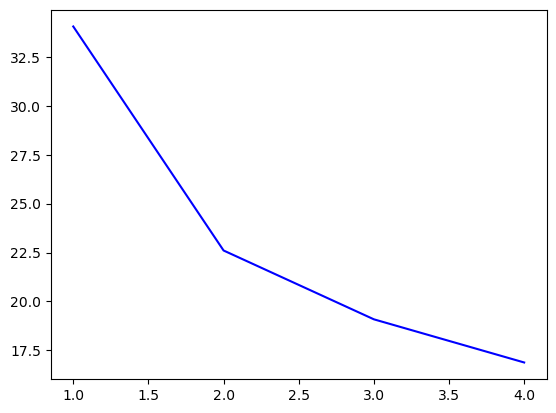

VAL: [Epoch 3/20] [Batch 0/40] [D loss: 0.12883438169956207] [G loss: 18.21892547607422]
VAL: [Epoch 3/20] [Batch 1/40] [D loss: 1.1365420818328857] [G loss: 18.652912139892578]
VAL: [Epoch 3/20] [Batch 2/40] [D loss: 1.3377176523208618] [G loss: 18.301742553710938]
VAL: [Epoch 3/20] [Batch 3/40] [D loss: 1.589248776435852] [G loss: 14.972840309143066]
VAL: [Epoch 3/20] [Batch 4/40] [D loss: 0.6747827529907227] [G loss: 18.441003799438477]
VAL: [Epoch 3/20] [Batch 5/40] [D loss: 0.5352992415428162] [G loss: 19.492603302001953]
VAL: [Epoch 3/20] [Batch 6/40] [D loss: 1.4744315147399902] [G loss: 18.122407913208008]
VAL: [Epoch 3/20] [Batch 7/40] [D loss: 0.2729378640651703] [G loss: 17.698421478271484]
VAL: [Epoch 3/20] [Batch 8/40] [D loss: 0.839200496673584] [G loss: 16.366640090942383]
VAL: [Epoch 3/20] [Batch 9/40] [D loss: 0.6908493041992188] [G loss: 18.722566604614258]
[Epoch 4/20] [Batch 0/40] [D loss: 0.19410893321037292] [G loss: 16.094383239746094]
[Epoch 4/20] [Batch 1/40] [

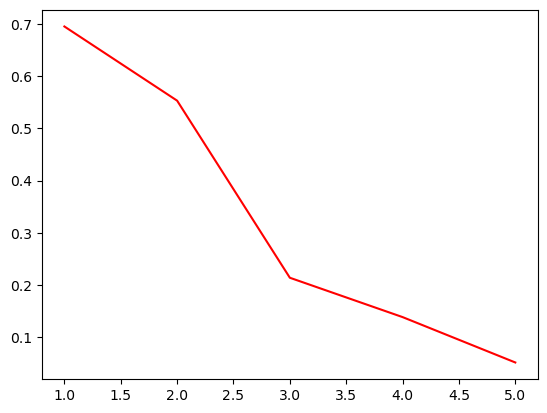

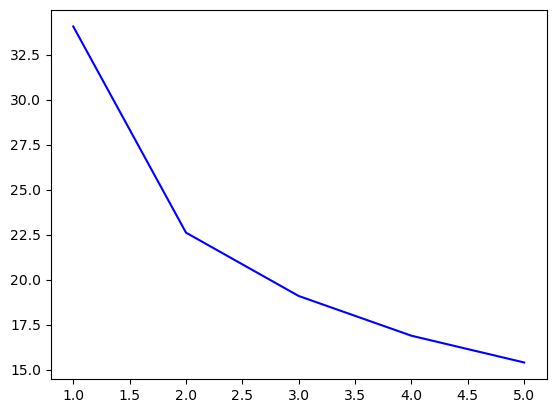

VAL: [Epoch 4/20] [Batch 0/40] [D loss: 0.09137692302465439] [G loss: 16.739105224609375]
VAL: [Epoch 4/20] [Batch 1/40] [D loss: 0.84684818983078] [G loss: 16.858604431152344]
VAL: [Epoch 4/20] [Batch 2/40] [D loss: 0.31122058629989624] [G loss: 16.743976593017578]
VAL: [Epoch 4/20] [Batch 3/40] [D loss: 0.4920630156993866] [G loss: 13.407795906066895]
VAL: [Epoch 4/20] [Batch 4/40] [D loss: 0.18601873517036438] [G loss: 17.34538459777832]
VAL: [Epoch 4/20] [Batch 5/40] [D loss: 0.4073217213153839] [G loss: 17.97260093688965]
VAL: [Epoch 4/20] [Batch 6/40] [D loss: 0.693367063999176] [G loss: 16.62835121154785]
VAL: [Epoch 4/20] [Batch 7/40] [D loss: 0.1194647029042244] [G loss: 16.061185836791992]
VAL: [Epoch 4/20] [Batch 8/40] [D loss: 0.2535322904586792] [G loss: 15.14821720123291]
VAL: [Epoch 4/20] [Batch 9/40] [D loss: 0.6408336162567139] [G loss: 17.298688888549805]
[Epoch 5/20] [Batch 0/40] [D loss: 0.08609718829393387] [G loss: 14.927135467529297]
[Epoch 5/20] [Batch 1/40] [D 

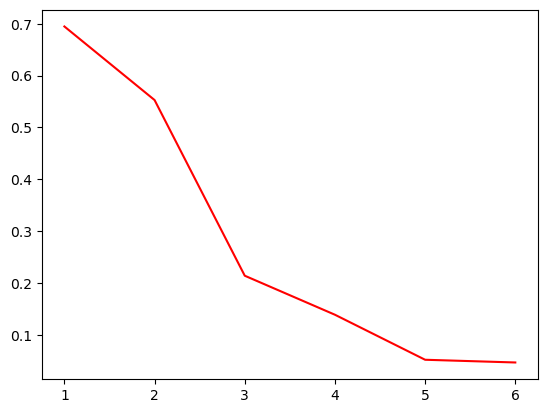

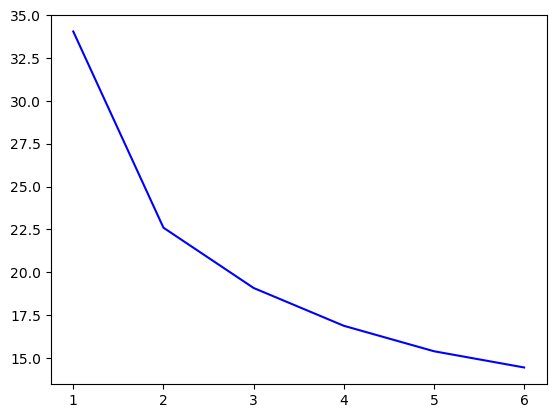

VAL: [Epoch 5/20] [Batch 0/40] [D loss: 0.035979583859443665] [G loss: 15.602400779724121]
VAL: [Epoch 5/20] [Batch 1/40] [D loss: 0.5808731913566589] [G loss: 15.88991641998291]
VAL: [Epoch 5/20] [Batch 2/40] [D loss: 0.3714199364185333] [G loss: 15.520060539245605]
VAL: [Epoch 5/20] [Batch 3/40] [D loss: 0.30736425518989563] [G loss: 12.662445068359375]
VAL: [Epoch 5/20] [Batch 4/40] [D loss: 0.3374024033546448] [G loss: 16.45774269104004]
VAL: [Epoch 5/20] [Batch 5/40] [D loss: 0.578863799571991] [G loss: 16.690563201904297]
VAL: [Epoch 5/20] [Batch 6/40] [D loss: 0.5866827964782715] [G loss: 15.736505508422852]
VAL: [Epoch 5/20] [Batch 7/40] [D loss: 0.24376682937145233] [G loss: 15.032727241516113]
VAL: [Epoch 5/20] [Batch 8/40] [D loss: 0.44660985469818115] [G loss: 14.16144847869873]
VAL: [Epoch 5/20] [Batch 9/40] [D loss: 0.2691505551338196] [G loss: 16.303430557250977]
[Epoch 6/20] [Batch 0/40] [D loss: 0.01446112897247076] [G loss: 13.94326114654541]
[Epoch 6/20] [Batch 1/40]

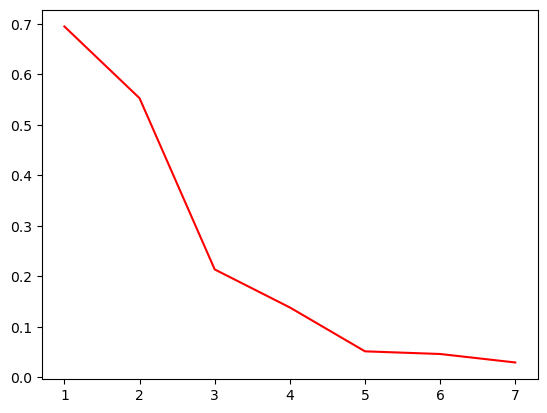

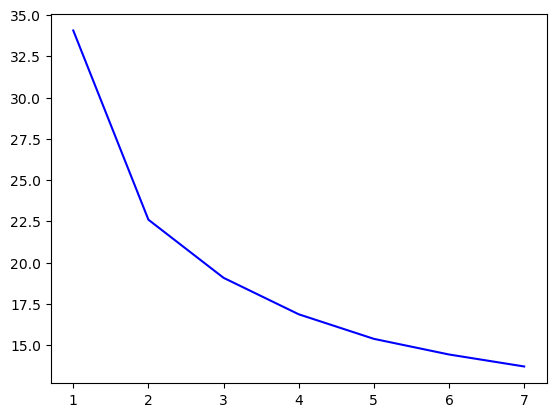

VAL: [Epoch 6/20] [Batch 0/40] [D loss: 0.025128202512860298] [G loss: 14.303688049316406]
VAL: [Epoch 6/20] [Batch 1/40] [D loss: 0.45435693860054016] [G loss: 14.964035987854004]
VAL: [Epoch 6/20] [Batch 2/40] [D loss: 0.33159923553466797] [G loss: 14.428969383239746]
VAL: [Epoch 6/20] [Batch 3/40] [D loss: 0.2279731184244156] [G loss: 11.814082145690918]
VAL: [Epoch 6/20] [Batch 4/40] [D loss: 0.463424414396286] [G loss: 15.469259262084961]
VAL: [Epoch 6/20] [Batch 5/40] [D loss: 0.21969349682331085] [G loss: 15.572447776794434]
VAL: [Epoch 6/20] [Batch 6/40] [D loss: 0.304379403591156] [G loss: 14.945589065551758]
VAL: [Epoch 6/20] [Batch 7/40] [D loss: 0.37970271706581116] [G loss: 13.926017761230469]
VAL: [Epoch 6/20] [Batch 8/40] [D loss: 0.3592456877231598] [G loss: 13.314671516418457]
VAL: [Epoch 6/20] [Batch 9/40] [D loss: 0.14816901087760925] [G loss: 15.41106128692627]
[Epoch 7/20] [Batch 0/40] [D loss: 0.01840314455330372] [G loss: 13.176618576049805]
[Epoch 7/20] [Batch 1

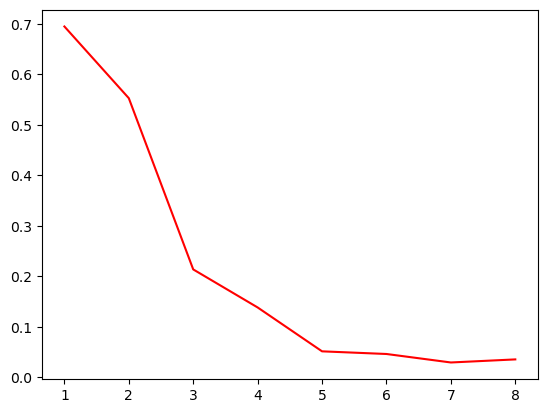

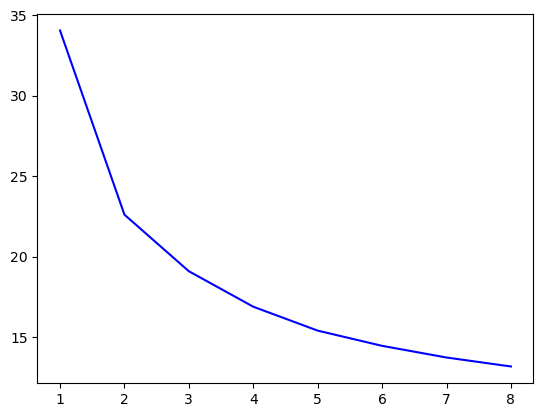

VAL: [Epoch 7/20] [Batch 0/40] [D loss: 0.01115664467215538] [G loss: 13.58895206451416]
VAL: [Epoch 7/20] [Batch 1/40] [D loss: 0.17102083563804626] [G loss: 14.602017402648926]
VAL: [Epoch 7/20] [Batch 2/40] [D loss: 0.3106051981449127] [G loss: 13.812925338745117]
VAL: [Epoch 7/20] [Batch 3/40] [D loss: 0.11048290133476257] [G loss: 11.397311210632324]
VAL: [Epoch 7/20] [Batch 4/40] [D loss: 0.14272630214691162] [G loss: 15.048264503479004]
VAL: [Epoch 7/20] [Batch 5/40] [D loss: 0.23331619799137115] [G loss: 14.976725578308105]
VAL: [Epoch 7/20] [Batch 6/40] [D loss: 0.15337246656417847] [G loss: 14.226324081420898]
VAL: [Epoch 7/20] [Batch 7/40] [D loss: 0.1479073017835617] [G loss: 13.175603866577148]
VAL: [Epoch 7/20] [Batch 8/40] [D loss: 0.09334394335746765] [G loss: 12.737865447998047]
VAL: [Epoch 7/20] [Batch 9/40] [D loss: 0.04820580407977104] [G loss: 14.53166389465332]
[Epoch 8/20] [Batch 0/40] [D loss: 0.008355391211807728] [G loss: 12.681117057800293]
[Epoch 8/20] [Batc

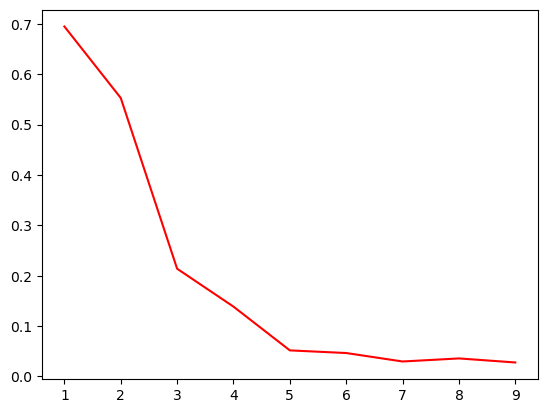

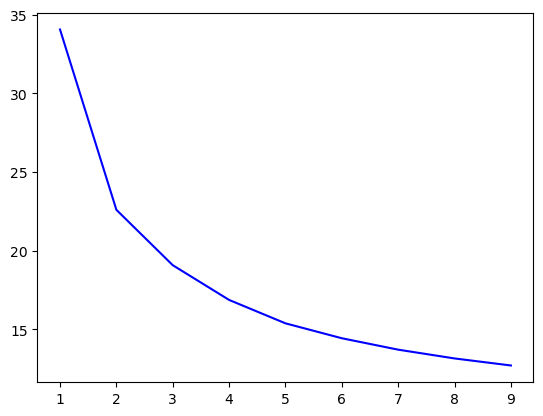

VAL: [Epoch 8/20] [Batch 0/40] [D loss: 0.008828448131680489] [G loss: 13.084461212158203]
VAL: [Epoch 8/20] [Batch 1/40] [D loss: 0.3934986889362335] [G loss: 14.05553913116455]
VAL: [Epoch 8/20] [Batch 2/40] [D loss: 0.301822692155838] [G loss: 13.212456703186035]
VAL: [Epoch 8/20] [Batch 3/40] [D loss: 0.046976346522569656] [G loss: 11.422554016113281]
VAL: [Epoch 8/20] [Batch 4/40] [D loss: 0.363002747297287] [G loss: 14.702582359313965]
VAL: [Epoch 8/20] [Batch 5/40] [D loss: 0.3496047854423523] [G loss: 14.040217399597168]
VAL: [Epoch 8/20] [Batch 6/40] [D loss: 0.15493199229240417] [G loss: 13.580964088439941]
VAL: [Epoch 8/20] [Batch 7/40] [D loss: 0.05093441531062126] [G loss: 12.785179138183594]
VAL: [Epoch 8/20] [Batch 8/40] [D loss: 0.3640878200531006] [G loss: 12.088824272155762]
VAL: [Epoch 8/20] [Batch 9/40] [D loss: 0.11188448965549469] [G loss: 14.377294540405273]
[Epoch 9/20] [Batch 0/40] [D loss: 0.014698943123221397] [G loss: 12.13063907623291]
[Epoch 9/20] [Batch 1

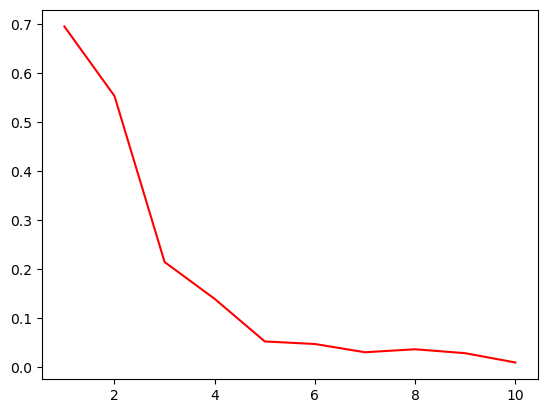

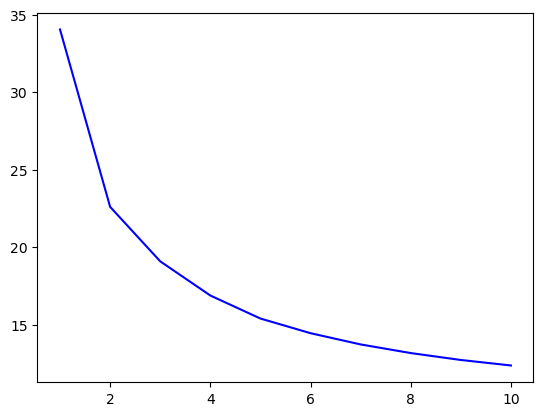

VAL: [Epoch 9/20] [Batch 0/40] [D loss: 0.01278748456388712] [G loss: 12.873066902160645]
VAL: [Epoch 9/20] [Batch 1/40] [D loss: 0.3095323145389557] [G loss: 14.045422554016113]
VAL: [Epoch 9/20] [Batch 2/40] [D loss: 0.3886318802833557] [G loss: 13.15850830078125]
VAL: [Epoch 9/20] [Batch 3/40] [D loss: 0.034421805292367935] [G loss: 10.88596248626709]
VAL: [Epoch 9/20] [Batch 4/40] [D loss: 0.23556727170944214] [G loss: 14.71580982208252]
VAL: [Epoch 9/20] [Batch 5/40] [D loss: 0.6113945841789246] [G loss: 14.448981285095215]
VAL: [Epoch 9/20] [Batch 6/40] [D loss: 0.08274319767951965] [G loss: 13.532837867736816]
VAL: [Epoch 9/20] [Batch 7/40] [D loss: 0.1106799840927124] [G loss: 12.361311912536621]
VAL: [Epoch 9/20] [Batch 8/40] [D loss: 0.18073615431785583] [G loss: 12.39017105102539]
VAL: [Epoch 9/20] [Batch 9/40] [D loss: 0.1323443055152893] [G loss: 14.044382095336914]
[Epoch 10/20] [Batch 0/40] [D loss: 0.004079753533005714] [G loss: 12.254944801330566]
[Epoch 10/20] [Batch 

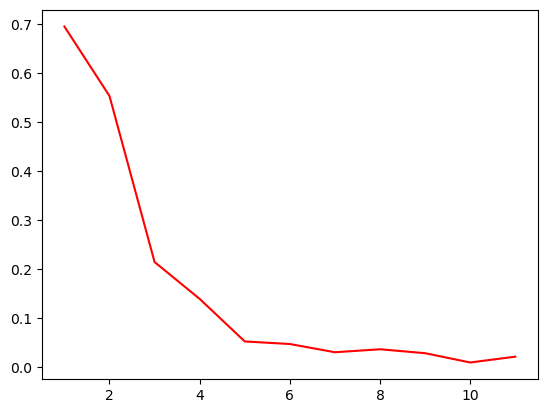

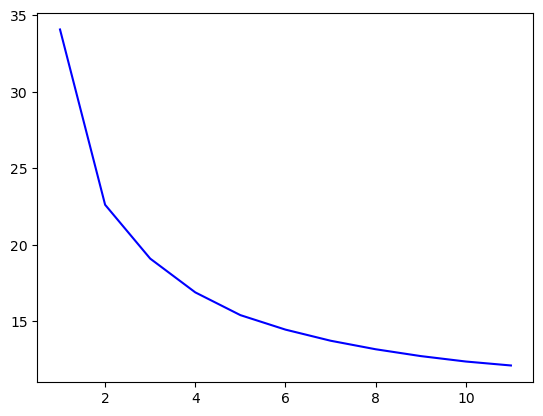

VAL: [Epoch 10/20] [Batch 0/40] [D loss: 0.013480663299560547] [G loss: 12.531062126159668]
VAL: [Epoch 10/20] [Batch 1/40] [D loss: 1.0044257640838623] [G loss: 13.432225227355957]
VAL: [Epoch 10/20] [Batch 2/40] [D loss: 0.2548656165599823] [G loss: 12.603238105773926]
VAL: [Epoch 10/20] [Batch 3/40] [D loss: 0.04202576354146004] [G loss: 10.329521179199219]
VAL: [Epoch 10/20] [Batch 4/40] [D loss: 0.11276619881391525] [G loss: 14.187431335449219]
VAL: [Epoch 10/20] [Batch 5/40] [D loss: 0.7148143649101257] [G loss: 13.995418548583984]
VAL: [Epoch 10/20] [Batch 6/40] [D loss: 0.31186336278915405] [G loss: 12.950035095214844]
VAL: [Epoch 10/20] [Batch 7/40] [D loss: 0.09852870553731918] [G loss: 11.566259384155273]
VAL: [Epoch 10/20] [Batch 8/40] [D loss: 0.06562704592943192] [G loss: 11.730277061462402]
VAL: [Epoch 10/20] [Batch 9/40] [D loss: 0.05474279820919037] [G loss: 13.512547492980957]
[Epoch 11/20] [Batch 0/40] [D loss: 0.008036182262003422] [G loss: 11.689573287963867]
[Epoc

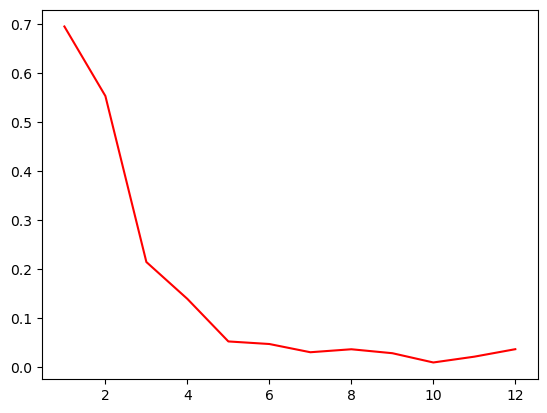

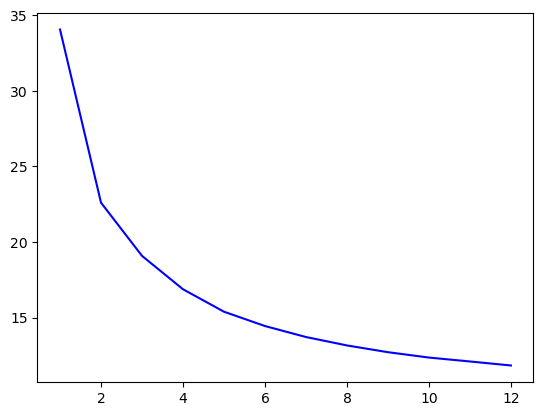

VAL: [Epoch 11/20] [Batch 0/40] [D loss: 0.036121223121881485] [G loss: 11.502094268798828]
VAL: [Epoch 11/20] [Batch 1/40] [D loss: 0.5637011528015137] [G loss: 12.821056365966797]
VAL: [Epoch 11/20] [Batch 2/40] [D loss: 0.12956593930721283] [G loss: 12.003294944763184]
VAL: [Epoch 11/20] [Batch 3/40] [D loss: 0.03977856785058975] [G loss: 9.950201988220215]
VAL: [Epoch 11/20] [Batch 4/40] [D loss: 0.03179371356964111] [G loss: 13.293150901794434]
VAL: [Epoch 11/20] [Batch 5/40] [D loss: 0.0724455863237381] [G loss: 13.180633544921875]
VAL: [Epoch 11/20] [Batch 6/40] [D loss: 0.23395584523677826] [G loss: 12.370664596557617]
VAL: [Epoch 11/20] [Batch 7/40] [D loss: 0.055144052952528] [G loss: 10.956298828125]
VAL: [Epoch 11/20] [Batch 8/40] [D loss: 0.06926575303077698] [G loss: 11.110373497009277]
VAL: [Epoch 11/20] [Batch 9/40] [D loss: 0.013295207172632217] [G loss: 12.868094444274902]
[Epoch 12/20] [Batch 0/40] [D loss: 0.00919034332036972] [G loss: 11.134528160095215]
[Epoch 12/

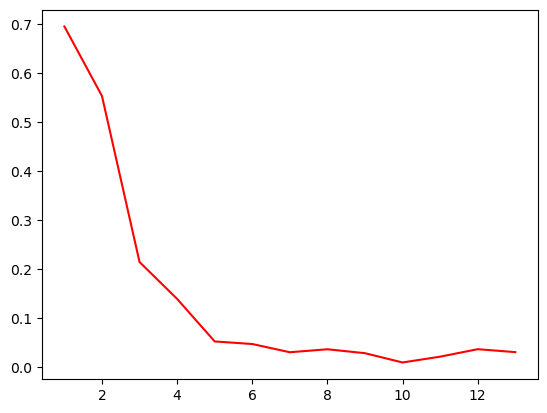

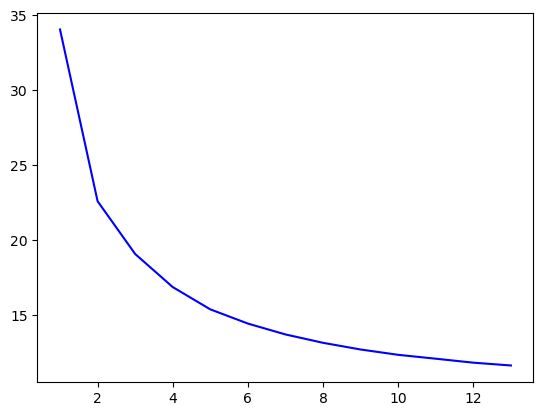

VAL: [Epoch 12/20] [Batch 0/40] [D loss: 0.042550522834062576] [G loss: 10.902626991271973]
VAL: [Epoch 12/20] [Batch 1/40] [D loss: 0.6910086274147034] [G loss: 12.692996978759766]
VAL: [Epoch 12/20] [Batch 2/40] [D loss: 0.05287982523441315] [G loss: 11.603604316711426]
VAL: [Epoch 12/20] [Batch 3/40] [D loss: 0.06469720602035522] [G loss: 10.240334510803223]
VAL: [Epoch 12/20] [Batch 4/40] [D loss: 0.021914208307862282] [G loss: 12.934847831726074]
VAL: [Epoch 12/20] [Batch 5/40] [D loss: 0.0395645871758461] [G loss: 12.380858421325684]
VAL: [Epoch 12/20] [Batch 6/40] [D loss: 0.08248798549175262] [G loss: 11.914128303527832]
VAL: [Epoch 12/20] [Batch 7/40] [D loss: 0.03782431036233902] [G loss: 10.58608627319336]
VAL: [Epoch 12/20] [Batch 8/40] [D loss: 0.04114865884184837] [G loss: 10.512822151184082]
VAL: [Epoch 12/20] [Batch 9/40] [D loss: 0.12927734851837158] [G loss: 12.55460262298584]
[Epoch 13/20] [Batch 0/40] [D loss: 0.002950333058834076] [G loss: 10.729166984558105]
[Epoc

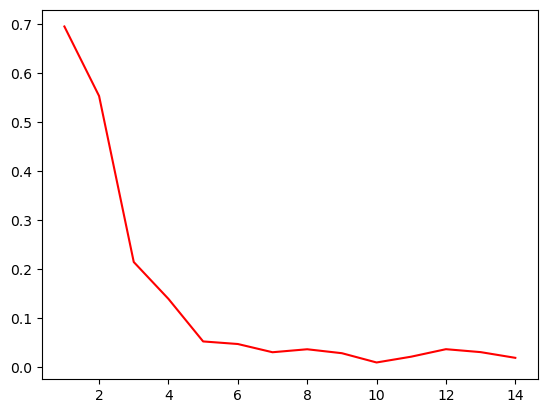

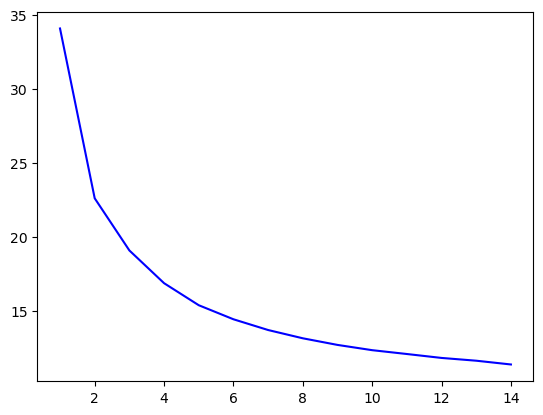

VAL: [Epoch 13/20] [Batch 0/40] [D loss: 0.02267826348543167] [G loss: 10.896380424499512]
VAL: [Epoch 13/20] [Batch 1/40] [D loss: 0.8473783731460571] [G loss: 12.491225242614746]
VAL: [Epoch 13/20] [Batch 2/40] [D loss: 0.20121589303016663] [G loss: 11.548377990722656]
VAL: [Epoch 13/20] [Batch 3/40] [D loss: 0.07066944986581802] [G loss: 9.55036735534668]
VAL: [Epoch 13/20] [Batch 4/40] [D loss: 0.05241052433848381] [G loss: 12.926545143127441]
VAL: [Epoch 13/20] [Batch 5/40] [D loss: 0.17375756800174713] [G loss: 12.835659980773926]
VAL: [Epoch 13/20] [Batch 6/40] [D loss: 0.23175567388534546] [G loss: 11.870017051696777]
VAL: [Epoch 13/20] [Batch 7/40] [D loss: 0.047957807779312134] [G loss: 10.346565246582031]
VAL: [Epoch 13/20] [Batch 8/40] [D loss: 0.12176939100027084] [G loss: 10.635160446166992]
VAL: [Epoch 13/20] [Batch 9/40] [D loss: 0.022804435342550278] [G loss: 12.052205085754395]
[Epoch 14/20] [Batch 0/40] [D loss: 0.002858209190890193] [G loss: 10.70242977142334]
[Epoc

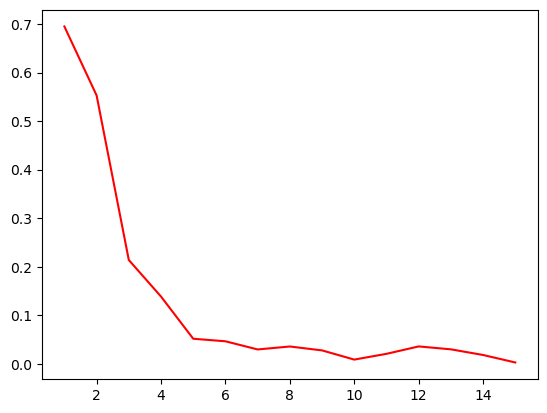

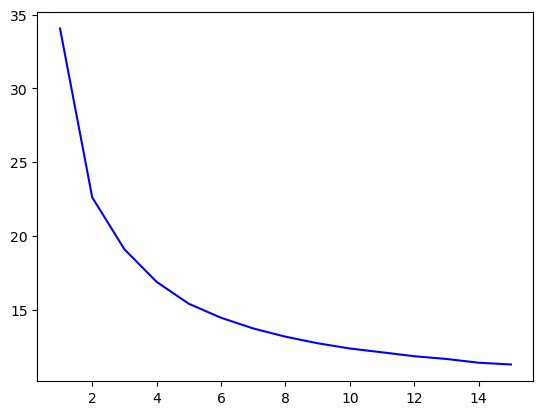

VAL: [Epoch 14/20] [Batch 0/40] [D loss: 0.01232711598277092] [G loss: 10.08398151397705]
VAL: [Epoch 14/20] [Batch 1/40] [D loss: 0.676853597164154] [G loss: 12.081043243408203]
VAL: [Epoch 14/20] [Batch 2/40] [D loss: 0.07501070201396942] [G loss: 10.990641593933105]
VAL: [Epoch 14/20] [Batch 3/40] [D loss: 0.025514092296361923] [G loss: 9.528112411499023]
VAL: [Epoch 14/20] [Batch 4/40] [D loss: 0.015350712463259697] [G loss: 12.374579429626465]
VAL: [Epoch 14/20] [Batch 5/40] [D loss: 0.13591524958610535] [G loss: 11.913321495056152]
VAL: [Epoch 14/20] [Batch 6/40] [D loss: 0.09224334359169006] [G loss: 11.337502479553223]
VAL: [Epoch 14/20] [Batch 7/40] [D loss: 0.0307786762714386] [G loss: 9.704793930053711]
VAL: [Epoch 14/20] [Batch 8/40] [D loss: 0.03248931095004082] [G loss: 9.895657539367676]
VAL: [Epoch 14/20] [Batch 9/40] [D loss: 0.007790453732013702] [G loss: 11.54904556274414]
[Epoch 15/20] [Batch 0/40] [D loss: 0.0014718216843903065] [G loss: 10.134946823120117]
[Epoch 

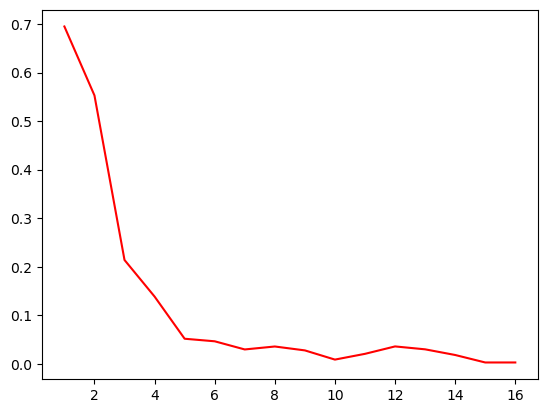

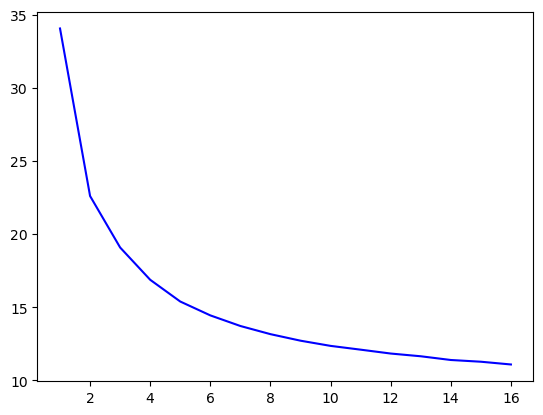

VAL: [Epoch 15/20] [Batch 0/40] [D loss: 0.012567136436700821] [G loss: 9.776426315307617]
VAL: [Epoch 15/20] [Batch 1/40] [D loss: 0.6551475524902344] [G loss: 11.968618392944336]
VAL: [Epoch 15/20] [Batch 2/40] [D loss: 0.08233387768268585] [G loss: 10.700326919555664]
VAL: [Epoch 15/20] [Batch 3/40] [D loss: 0.025340737774968147] [G loss: 9.518277168273926]
VAL: [Epoch 15/20] [Batch 4/40] [D loss: 0.01228420715779066] [G loss: 12.071615219116211]
VAL: [Epoch 15/20] [Batch 5/40] [D loss: 0.11933805048465729] [G loss: 11.580938339233398]
VAL: [Epoch 15/20] [Batch 6/40] [D loss: 0.1176660880446434] [G loss: 11.03256893157959]
VAL: [Epoch 15/20] [Batch 7/40] [D loss: 0.02585332840681076] [G loss: 9.403029441833496]
VAL: [Epoch 15/20] [Batch 8/40] [D loss: 0.05023511126637459] [G loss: 9.56955623626709]
VAL: [Epoch 15/20] [Batch 9/40] [D loss: 0.005824366584420204] [G loss: 11.342242240905762]
[Epoch 16/20] [Batch 0/40] [D loss: 0.0010720238788053393] [G loss: 9.884103775024414]
[Epoch 1

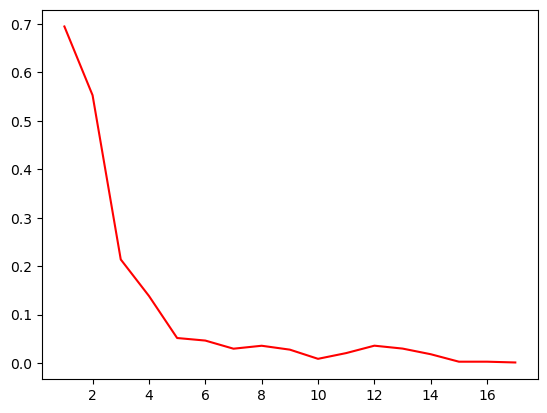

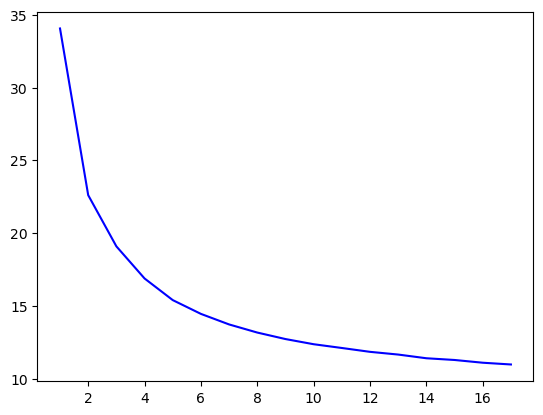

VAL: [Epoch 16/20] [Batch 0/40] [D loss: 0.01128318626433611] [G loss: 9.529396057128906]
VAL: [Epoch 16/20] [Batch 1/40] [D loss: 0.6741213798522949] [G loss: 11.74374008178711]
VAL: [Epoch 16/20] [Batch 2/40] [D loss: 0.09042271971702576] [G loss: 10.489974975585938]
VAL: [Epoch 16/20] [Batch 3/40] [D loss: 0.024994410574436188] [G loss: 9.19872760772705]
VAL: [Epoch 16/20] [Batch 4/40] [D loss: 0.013342533260583878] [G loss: 11.922114372253418]
VAL: [Epoch 16/20] [Batch 5/40] [D loss: 0.1381009817123413] [G loss: 11.517926216125488]
VAL: [Epoch 16/20] [Batch 6/40] [D loss: 0.1522376537322998] [G loss: 10.819035530090332]
VAL: [Epoch 16/20] [Batch 7/40] [D loss: 0.029143493622541428] [G loss: 9.11567211151123]
VAL: [Epoch 16/20] [Batch 8/40] [D loss: 0.061947114765644073] [G loss: 9.366504669189453]
VAL: [Epoch 16/20] [Batch 9/40] [D loss: 0.005182044580578804] [G loss: 11.008708953857422]
[Epoch 17/20] [Batch 0/40] [D loss: 0.0008113346411846578] [G loss: 9.670953750610352]
[Epoch 1

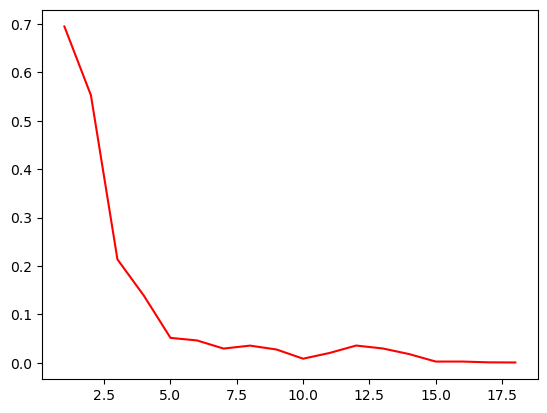

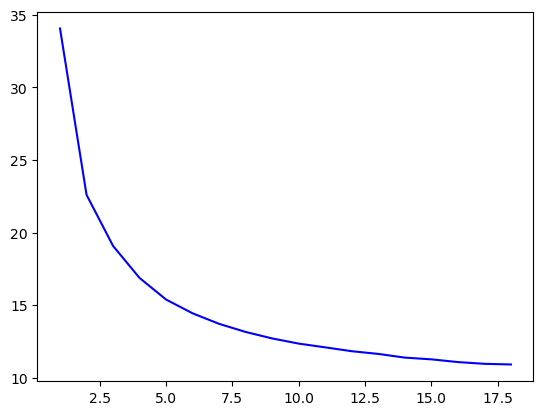

VAL: [Epoch 17/20] [Batch 0/40] [D loss: 0.008511129766702652] [G loss: 9.2737455368042]
VAL: [Epoch 17/20] [Batch 1/40] [D loss: 0.655159056186676] [G loss: 11.77823543548584]
VAL: [Epoch 17/20] [Batch 2/40] [D loss: 0.07483521103858948] [G loss: 10.371332168579102]
VAL: [Epoch 17/20] [Batch 3/40] [D loss: 0.02115512639284134] [G loss: 9.357584953308105]
VAL: [Epoch 17/20] [Batch 4/40] [D loss: 0.009926714934408665] [G loss: 11.812352180480957]
VAL: [Epoch 17/20] [Batch 5/40] [D loss: 0.11567287892103195] [G loss: 11.346059799194336]
VAL: [Epoch 17/20] [Batch 6/40] [D loss: 0.12279253453016281] [G loss: 10.678123474121094]
VAL: [Epoch 17/20] [Batch 7/40] [D loss: 0.02535330131649971] [G loss: 9.002607345581055]
VAL: [Epoch 17/20] [Batch 8/40] [D loss: 0.037096455693244934] [G loss: 9.286301612854004]
VAL: [Epoch 17/20] [Batch 9/40] [D loss: 0.004182735923677683] [G loss: 10.92688274383545]
[Epoch 18/20] [Batch 0/40] [D loss: 0.0006876487168483436] [G loss: 9.637442588806152]
[Epoch 18

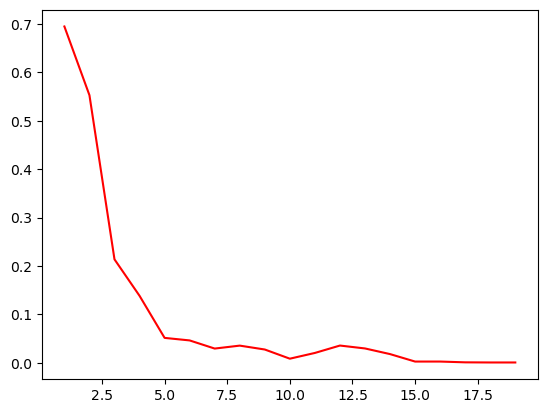

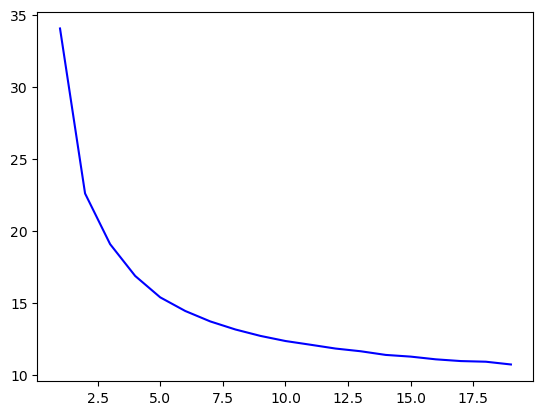

VAL: [Epoch 18/20] [Batch 0/40] [D loss: 0.006937675643712282] [G loss: 9.23548698425293]
VAL: [Epoch 18/20] [Batch 1/40] [D loss: 0.6793817281723022] [G loss: 11.671829223632812]
VAL: [Epoch 18/20] [Batch 2/40] [D loss: 0.07981732487678528] [G loss: 10.219120025634766]
VAL: [Epoch 18/20] [Batch 3/40] [D loss: 0.024037521332502365] [G loss: 9.266643524169922]
VAL: [Epoch 18/20] [Batch 4/40] [D loss: 0.01101823803037405] [G loss: 11.63077163696289]
VAL: [Epoch 18/20] [Batch 5/40] [D loss: 0.09381752461194992] [G loss: 11.197250366210938]
VAL: [Epoch 18/20] [Batch 6/40] [D loss: 0.15224960446357727] [G loss: 10.524365425109863]
VAL: [Epoch 18/20] [Batch 7/40] [D loss: 0.030372455716133118] [G loss: 8.869154930114746]
VAL: [Epoch 18/20] [Batch 8/40] [D loss: 0.04926897957921028] [G loss: 9.078929901123047]
VAL: [Epoch 18/20] [Batch 9/40] [D loss: 0.0038329651579260826] [G loss: 10.878860473632812]
[Epoch 19/20] [Batch 0/40] [D loss: 0.0006814676453359425] [G loss: 9.461813926696777]
[Epoc

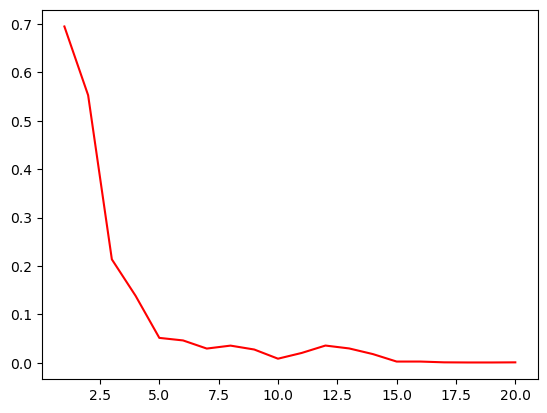

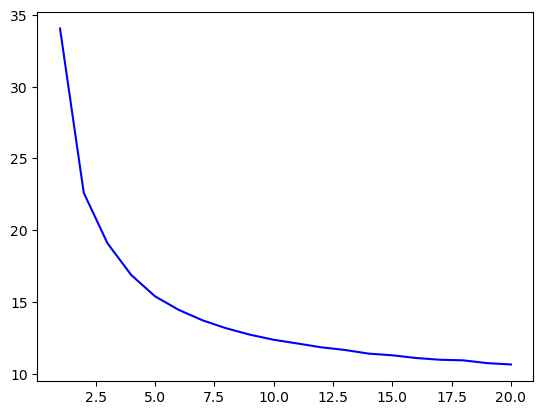

VAL: [Epoch 19/20] [Batch 0/40] [D loss: 0.006633171811699867] [G loss: 9.275842666625977]
VAL: [Epoch 19/20] [Batch 1/40] [D loss: 0.8264205455780029] [G loss: 11.937236785888672]
VAL: [Epoch 19/20] [Batch 2/40] [D loss: 0.17334242165088654] [G loss: 10.236196517944336]
VAL: [Epoch 19/20] [Batch 3/40] [D loss: 0.037874385714530945] [G loss: 9.749153137207031]
VAL: [Epoch 19/20] [Batch 4/40] [D loss: 0.08334021270275116] [G loss: 11.804548263549805]
VAL: [Epoch 19/20] [Batch 5/40] [D loss: 0.2732413411140442] [G loss: 11.231708526611328]
VAL: [Epoch 19/20] [Batch 6/40] [D loss: 0.2343333512544632] [G loss: 10.760156631469727]
VAL: [Epoch 19/20] [Batch 7/40] [D loss: 0.1222858726978302] [G loss: 9.04356861114502]
VAL: [Epoch 19/20] [Batch 8/40] [D loss: 0.14711245894432068] [G loss: 9.20734977722168]
VAL: [Epoch 19/20] [Batch 9/40] [D loss: 0.009696603752672672] [G loss: 10.989028930664062]


In [11]:
train_loss_discriminator = []
train_loss_generator = []

val_loss_discriminator = []
val_loss_generator = []

# Iterate over the number of epochs
for epoch in range(epochs):

    # Used to calc average loss per epoch
    epoch_d_loss = 0
    epoch_g_loss = 0
    num_batches = 0

    # Iterate over the train data loader
    for i, data in enumerate(train_dl):

        # Access the data, the L channel and the ab channel respectively    
        L, abs_ = data["L"], data["ab"]
        
        # Send to device
        L = L.to(device)
        abs_ = abs_.to(device)

        # Get the batch size
        batch_size = L.size(0)

        # Adversarial ground truths
        valid = torch.ones((batch_size, 1), requires_grad=False).to(device)
        fake = torch.zeros((batch_size, 1), requires_grad=False).to(device)

        # -----------------
        #  Invoke Generator
        # -----------------
        # Generate images with U-Net
        generated_abs = generator(L)

        # ---------------------
        #  Train Discriminator ### THIS IS ALL FROM THE backward_D METHOD
        # ---------------------
        discriminator.train()

        # I am not sure if we need this
        for p in discriminator.parameters():
            p.requires_grad = True

        # Reset the optimizer
        optimizer_D.zero_grad()

        fake_image = torch.cat([L, generated_abs.detach()], dim = 1) # Detach prevents the discriminator backprop from going to the generator
        fake_preds = discriminator(fake_image)

        # Loss measures generator's ability to fool the discriminator
        LOSS_D_FAKE = adversarial_loss(fake_preds, fake)
        
        real_images = torch.cat([L, abs_], dim = 1)
        real_preds = discriminator(real_images)

        # Loss for real images
        LOSS_D_REAL = adversarial_loss(real_preds, valid)

        D_LOSS = (LOSS_D_FAKE + LOSS_D_REAL) / 2

        D_LOSS.backward()
        optimizer_D.step()

        # ---------------------
        #  Train Generator ### THIS IS ALL FROM THE backward_G METHOD
        # ---------------------
        generator.train()
        optimizer_G.zero_grad()

        # Set requires grad on discriminator to FALSE; IDK why currently
        for p in discriminator.parameters():
            p.requires_grad = False
        fake_image = torch.concat([L, generated_abs], dim = 1)
        fake_preds = discriminator(fake_image)
        LOSS_G_GAN = mce(fake_preds, valid)
        LOSS_L1 = l1_loss(generated_abs, abs_) * lambda_l1
        LOSS_G = LOSS_G_GAN + LOSS_L1
        LOSS_G.backward()
        optimizer_G.step()

        # Update trackers
        epoch_d_loss += D_LOSS.item()
        epoch_g_loss += LOSS_G.item()
        num_batches += 1

        # Print the progress
        print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(train_dl)}] [D loss: {D_LOSS.item()}] [G loss: {LOSS_G.item()}]")

    # Average loss per epoch
    avg_d_loss = epoch_d_loss / num_batches
    avg_g_loss = epoch_g_loss / num_batches

    train_loss_discriminator.append(avg_d_loss)
    train_loss_generator.append(avg_g_loss)
    
    epoch_range = range(1, epoch + 2)
    print(f"Lenght epochs: {len(epoch_range)} -- {epoch_range}")
    print("Loss D", train_loss_discriminator)
    print("Loss G", train_loss_generator)
    plt.plot(epoch_range, train_loss_discriminator, c = "r", label = "Discriminator Loss")
    plt.show()
    plt.plot(epoch_range, train_loss_generator, c = "b", label = "Generator Loss")
    plt.show()

    # Val Loop
    generator.eval()
    discriminator.eval()
    with torch.no_grad():

        # Trackers to calc average loss per epoch
        epoch_val_d_loss = 0
        epoch_val_g_loss = 0
        num_batches = 0
        for i, data in enumerate(val_dl):
            L, abs_ = data["L"], data["ab"]

            # Generate ab values
            generated_abs = generator(L)

            # Validate Discriminator
            fake_image = torch.cat([L, generated_abs.detach()], dim = 1)
            LOSS_D_FAKE = adversarial_loss(fake_preds, fake)
            real_images = torch.cat([L, abs_], dim = 1)
            real_preds = discriminator(real_images)
            LOSS_D_REAL = adversarial_loss(real_preds, valid)
            D_LOSS = (LOSS_D_FAKE + LOSS_D_REAL) / 2

            # Validate Generator
            fake_image = torch.concat([L, generated_abs], dim = 1)
            fake_preds = discriminator(fake_image)
            LOSS_G_GAN = mce(fake_preds, fake)
            LOSS_L1 = l1_loss(generated_abs, abs_) * lambda_l1
            LOSS_G = LOSS_G_GAN + LOSS_L1

            # Update trackers
            epoch_d_loss += D_LOSS.item()
            epoch_g_loss += LOSS_G.item()
            num_batches += 1

            # Print the progress
            print(f"VAL: [Epoch {epoch}/{epochs}] [Batch {i}/{len(train_dl)}] [D loss: {D_LOSS.item()}] [G loss: {LOSS_G.item()}]")

        # Average loss per epoch
        avg_val_d_loss = epoch_val_d_loss / num_batches
        avg_val_g_loss = epoch_val_g_loss / num_batches

        val_loss_discriminator.append(avg_d_loss)
        val_loss_generator.append(avg_g_loss)

